# Ultimate Data Science Challenge

In [17]:
#Import Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from datetime import timedelta
# from dateutil.relativedelta import relativedelta

%matplotlib inline

In [3]:
import json
from pandas.io.json import json_normalize

## Exploratory Data Analysis

__Let's visualize the login counts by binning the data in 15 minutes time intervals.__

Clean the data first

In [4]:
#Extract the data
df = pd.read_json('logins.json')
print (len(df))
print (df.login_time.dtypes)
df.describe()

93142
datetime64[ns]


,login_time
count,93142
unique,92265
top,1970-02-12 11:16:53
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


In [5]:
#Convert to timeseries and counts
ts = pd.DataFrame(index=df.login_time,columns=['count'])
ts['count'] = 1
# ts.isnull().sum()

In [6]:
#Aggregate to 15 minute intervals
ts = ts.resample('15T').sum()

print ("sum of logins -",ts['count'].sum())
print(len(ts))
print(ts.dtypes)
print ("Null values -",ts.isnull().sum())
ts.describe()

sum of logins - 93142.0
9788
count    float64
dtype: object
Null values - count    407
dtype: int64


,count
count,9381.000000
mean,9.928792
std,8.263146
min,1.000000
25%,4.000000
50%,8.000000
75%,14.000000
max,73.000000


## Descriptive Statistics

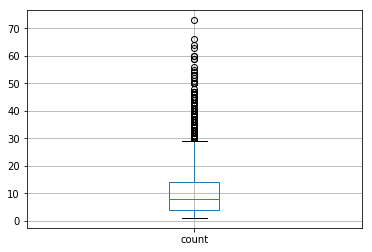

In [32]:
ts.boxplot('count')

The median is about 8 logins per 15-minute-interval but the data is skewed according to the boxplot, with many outliers with more than 30 logins. We have to explore further to find out if there are specific times of the day when this happens.

### Aggregations

#### Day-of-the-week

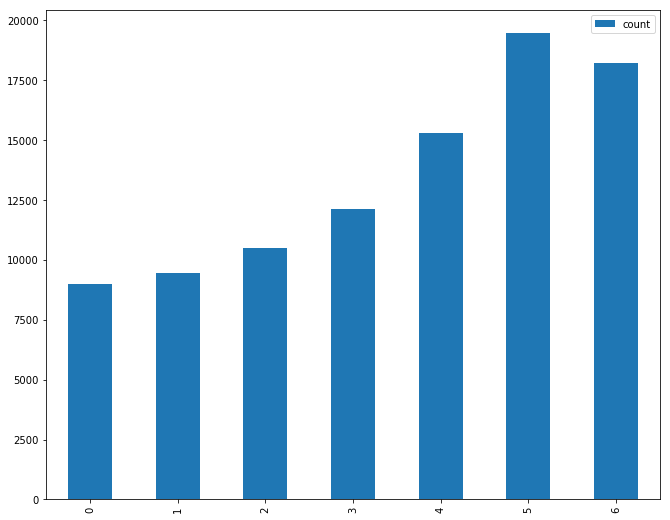

In [77]:
ts.groupby(ts.index.dayofweek).sum().plot(kind='bar')

This shows that the login (demand) is least on Monday, which goes on increasing, peaks out on Saturday and reduced a little bit on Sunday.

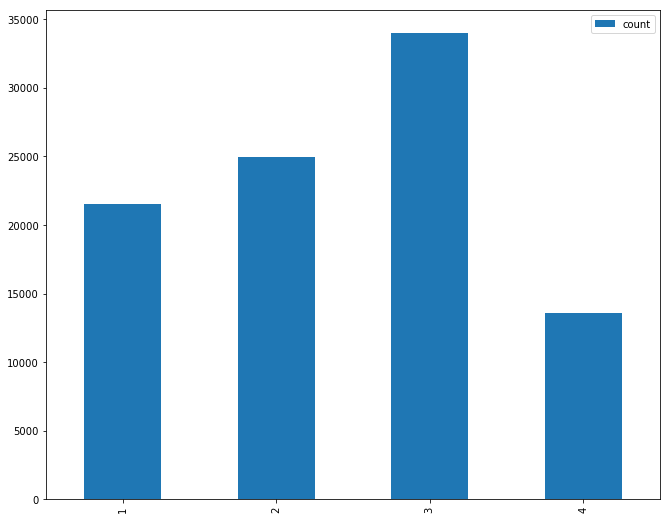

In [79]:
ts.groupby(ts.index.month).sum().plot(kind='bar')

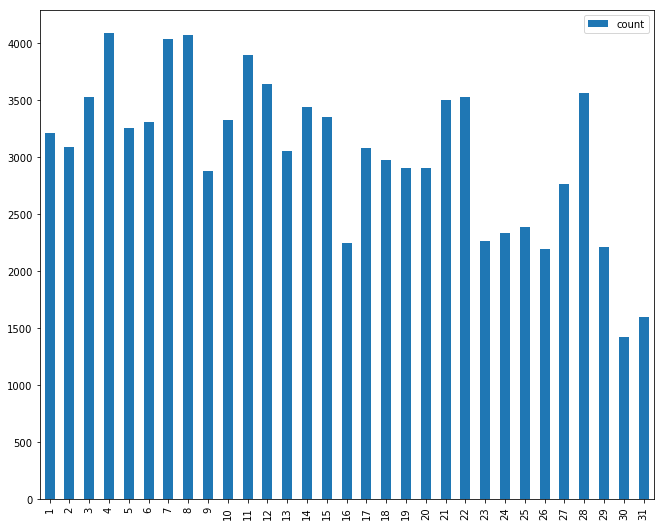

In [80]:
ts.groupby(ts.index.day).sum().plot(kind='bar')

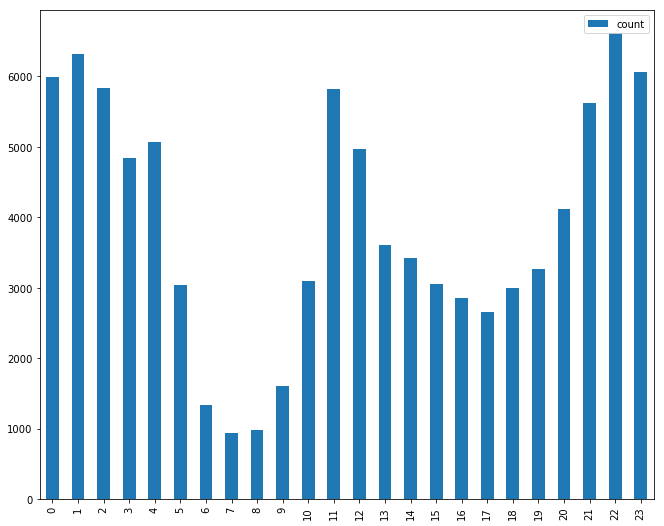

In [81]:
ts.groupby(ts.index.hour).sum().plot(kind='bar')

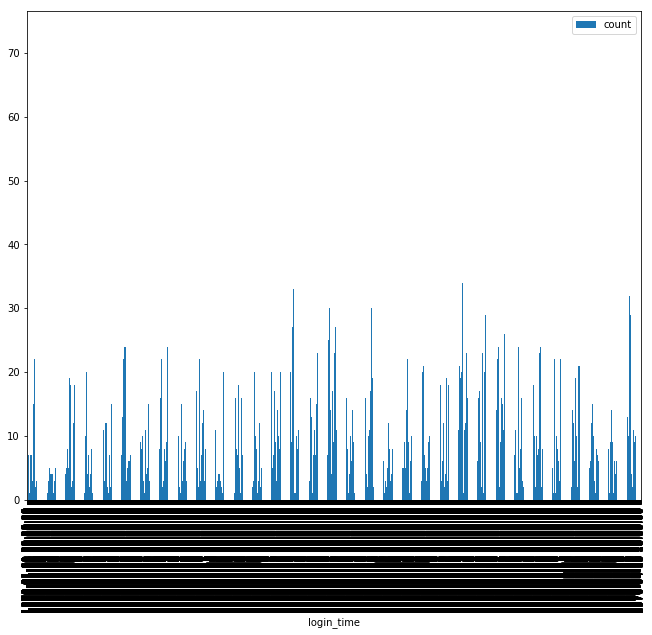

In [84]:
ts.plot(kind='bar') #or other function

# Predictive Analysis

In [221]:
# import data
with open('ultimate_data_challenge.json', 'r') as datafile:
        data = json.load(datafile)
df = pd.DataFrame(data)
# df.head()

In [222]:
#convert dtype to datetime
df['last_trip_date'] = pd.to_datetime(df.last_trip_date)
df['signup_date'] = pd.to_datetime(df.signup_date)

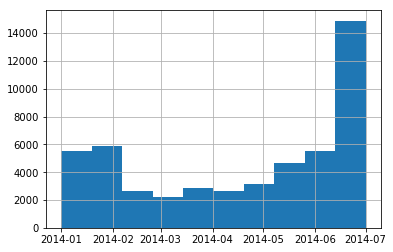

In [212]:
df.last_trip_date.hist()

## Defining 'Retention'

Let's define retention in 6th month as a binary class for the sake of classification -
1. It means the last_trip_date + one months is 'activity_date'
2. If timedelta between this date and signup date is less than 6 months, the user was inactive (0) in the sixth month. If it is more than or equal to six months, it was active (1)

Alternate way to do it -
1. Define 'last_activity_date' = 'last_trip_date' + 30 days
2. If difference between last activity date and signup date is less than or equal to 150 days (approx 5 months) we don't have retention (0). If we have activity in the 6th month, we have retention (1).

In [223]:
retention = []
df['last_activity_date'] = 30
df['last_activity_date'] = df['last_trip_date'] + df['last_activity_date'].values.astype("timedelta64[D]")
df[['last_activity_date','last_trip_date']].head()

for i in range(len(df)):
    
    if df.last_activity_date.iloc[i] - df.signup_date.iloc[i] <= pd.Timedelta('150d'):
        retention.append(0)
    else:
        retention.append(1)

retention[:10]

[1, 0, 0, 1, 0, 1, 0, 0, 0, 0]

** Drop the Dates **

In [224]:
df['retention'] = retention
df = df.drop('last_activity_date',axis=1)

In [225]:
df = df.drop(['last_trip_date','signup_date'],axis=1)

#### Types of features

In [226]:
categorical = ['city','phone']
numerical = ['avg_dist','avg_rating_by_driver','avg_rating_of_driver','avg_surge','surge_pct','trips_in_first_30_days','weekday_pct']
boolean = ['ultimate_black_user']

### Null Values
Let's skip imputation and delete the rows with missing values for convinience

In [227]:
cols = list(df.columns)
for column in cols:
    missing_count = df[column].isnull().values.sum()
    print (column, " - ", missing_count)

    if missing_count > 0:
        null_cols.append(column)
        df = df.loc[df[column].notnull()]
    
    missing_count = df[column].isnull().values.sum()
    print (column, " - ", missing_count,'\n')

avg_dist  -  0
avg_dist  -  0 

avg_rating_by_driver  -  201
avg_rating_by_driver  -  0 

avg_rating_of_driver  -  8055
avg_rating_of_driver  -  0 

avg_surge  -  0
avg_surge  -  0 

city  -  0
city  -  0 

phone  -  299
phone  -  0 

surge_pct  -  0
surge_pct  -  0 

trips_in_first_30_days  -  0
trips_in_first_30_days  -  0 

ultimate_black_user  -  0
ultimate_black_user  -  0 

weekday_pct  -  0
weekday_pct  -  0 

retention  -  0
retention  -  0 



### Encoding Categorical and Boolean Variables

In [228]:
for i in categorical:
    print (df[i].value_counts())

Winterfell        19161
Astapor           13509
King's Landing     8775
Name: city, dtype: int64
iPhone     29352
Android    12093
Name: phone, dtype: int64


In [230]:
from sklearn.preprocessing import LabelEncoder

#Categorical Encoding

df = df.loc[(df.phone == 'iPhone') | (df.phone == 'Android')] # clean phone column
    
    
for column in categorical:
    
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])

In [231]:
le = LabelEncoder() #boolean encoding
df['ultimate_black_user'] = le.fit_transform(df['ultimate_black_user'])

### Train Test Split

In [196]:
features = df.drop('retention',axis=1)

In [197]:
from sklearn.model_selection import train_test_split
X, Xtest, y, ytest = train_test_split(features, df['retention'],random_state=1,test_size=0.7)

### Define Evaluation Functions

In [198]:
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix, accuracy_score, recall_score

In [199]:
def roccurve(trainedevaluator,plotting=True,X=X,y=y,Xtest=Xtest,ytest=ytest):
    """ Plots ROC Curve and return area under the curve """
    
    #fit
    trainedevaluator.fit(X,y)
    
    #Find probabilities
    preds = trainedevaluator.predict_proba(Xtest)[:,1]
    
    #ROC
    fpr, tpr, _ = roc_curve(ytest, preds)
    
    #Area Under the curve
    area = auc(fpr,tpr)
    
    #Plot
    if plotting == True:
        plt.figure(figsize=(6,6))
        plt.xlim([0,1])
        plt.ylim([0,1])
        plt.title("ROC",fontsize=12)
        plt.xlabel("False Positive Rate")
        plt.ylabel("Ttrue Positive Rate")
        plt.plot(fpr,tpr)
        plt.plot([0,1],[0,1],'--',alpha=0.5)
    
    return area

In [200]:
def prediction(clf,X=X,y=y,Xtest=Xtest,ytest=ytest):
    clf.fit(X.values, y.values)
    preds = clf.predict(Xtest)
    cm = confusion_matrix(ytest, preds)
    
    print ("\nClassification Report on the Training data -\n", classification_report(y, clf.predict(X)))
    
    print("Accuracy Score =", accuracy_score(ytest, preds))
    print("Recall Score = ", recall_score(ytest,preds))
    
    print("\nConfusion Matrix -\n",cm)
    print("\nClassification Report -\n",classification_report(ytest, preds))
    try:
        print("Area under the ROC curve = {}".format(roccurve(clf)))
    except AttributeError:
        print ("Cannot draw ROC - predict_proba is not an attribute")

## Prediction

In [132]:
from sklearn.ensemble import RandomForestClassifier


Classification Report on the Training data -
              precision    recall  f1-score   support

          0       0.75      0.80      0.77      6360
          1       0.77      0.72      0.74      6073

avg / total       0.76      0.76      0.76     12433

Accuracy Score = 0.75041362195
Recall Score =  0.700511218404

Confusion Matrix -
 [[11905  3023]
 [ 4218  9866]]

Classification Report -
              precision    recall  f1-score   support

          0       0.74      0.80      0.77     14928
          1       0.77      0.70      0.73     14084

avg / total       0.75      0.75      0.75     29012

Area under the ROC curve = 0.8312343155125289


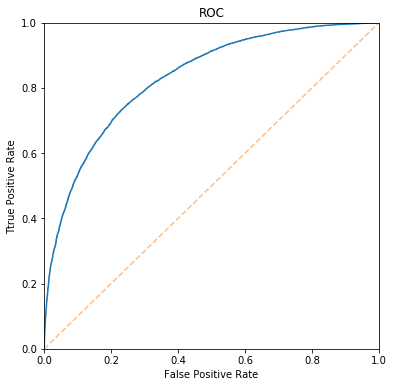

In [207]:
#Initial Run
rf = RandomForestClassifier(n_estimators=100, min_samples_split=200)
rf.fit(X,y)

prediction(rf)

### Feature Importances

(-1, 10)

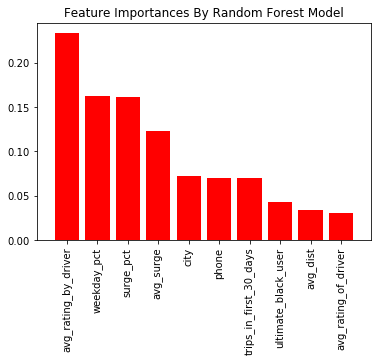

In [208]:
predictors = list(features.columns)

importances=rf.feature_importances_

indices = np.argsort(importances)[::-1]

sorted_important_features=[]
for i in indices:
    sorted_important_features.append(predictors[i])
    
plt.figure()
plt.title("Feature Importances By Random Forest Model")
plt.bar(range(np.size(predictors)), importances[indices],
       color="r")
plt.xticks(range(np.size(predictors)), sorted_important_features, rotation='vertical')

plt.xlim([-1, np.size(predictors)])